<a href="https://colab.research.google.com/github/josephcabezas/ecom-a-b-testing/blob/main/ecom_a_b_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedmohameddawoud/ecommerce-ab-testing")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ahmedmohameddawoud/ecommerce-ab-testing/versions/1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

dataset_files = os.listdir(path)
dataset_files

['ab_test.csv', 'countries_ab.csv']

In [ ]:
csv_file = os.path.join(path, 'ab_test.csv')
df = pd.read_csv(csv_file)
df.head()

In [ ]:
# change column names

df.columns = ['user_id', 'timestamp', 'group', 'landing_page', 'converted']
df.head()

In [6]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of unique users: {df.user_id.nunique()}')

Number of rows: 294478
Number of unique users: 290584


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# check for missing values

df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [9]:
# check if number of new_pages and treatment match

n_treat = df[df['group'] == 'treatment'].shape[0]
n_new_page = df[df['landing_page'] == 'new_page'].shape[0]

difference = n_treat - n_new_page
pd.DataFrame({
    'N treatment': [n_treat],
    'N new_page': [n_new_page],
    'Difference': [difference]
})

,N treatment,N new_page,Difference
0,147276,147239,37


In [10]:
# there's a mismatch in the data

df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [11]:
df_mismatch = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')\
                 |(df['group'] == 'control') & (df['landing_page'] == 'new_page')]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch}')
print(f'Percentage of mismatched rows: {percent_mismatch}')

Number of mismatched rows: 3893
Percentage of mismatched rows: 1.32


In [40]:
# go ahead an remove these mismatched rows, 1.32% is a neglible amnt

df2 = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')\
                 |(df['group'] == 'control') & (df['landing_page'] == 'old_page')]

len(df2)

290585

In [13]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [14]:
# check for mismatch again

df_mismatch = df2[(df2['group'] == 'treatment') & (df2['landing_page'] == 'old_page')\
                 |(df2['group'] == 'control') & (df2['landing_page'] == 'new_page')]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch}')
print(f'Percentage of mismatched rows: {percent_mismatch}')

Number of mismatched rows: 0
Percentage of mismatched rows: 0.0


In [15]:
# check for duplicate

len(df2) - df2.user_id.nunique()

1

In [16]:
# drop duplicate
df2 = df2.drop_duplicates(subset='user_id')
len(df2) - df2.user_id.nunique()

0

In [18]:
# deciding metric will be conversion,
# did web page convert the person to a paying customer?

# probability of a person converting regardless of webpage
df2.converted.mean() * 100

11.959708724499627

In [22]:
# probability of conversion depending on treatment group

df2.user_id = df2.user_id.astype(str)
df2.groupby('group').agg({col: 'mean' for col in df2.select_dtypes(include=['number']).columns}) * 100

,converted
group,
control,12.038630
treatment,11.880807


In [23]:
# probability that a person received the new webpage

pd.DataFrame(df2.landing_page.value_counts(normalize = True) *100)

,proportion
landing_page,
new_page,50.006194
old_page,49.993806




1.   The probability that someone received the new page is 50%
2. The probability of an individual converting regardless of the page they receive is 11.96%
3. Given that an individual was in the control group, the probability they converted is 12.04%
4. Given that an individual was in the treatment group, the probability they converted is 11.88%

*This suggest there is no significant difference in conversion rates between treatment and control groups*



Null Hypothesis, H0: Pold - Pnew >= 0
- no effect between variables

Alt Hypothesis, HA: Pold - Pnew < 0
- there is a relationship btwn variables

In [29]:
# creating sampling dist of difference in means

means_diff = []
size = df.shape[0]
for _ in range(10000):
    sample = df2.sample(size, replace=True)
    control_mean = sample[sample['group'] == 'control']['converted'].mean()
    treatment_mean = sample[sample['group'] == 'treatment']['converted'].mean()
    means_diff.append(control_mean - treatment_mean)

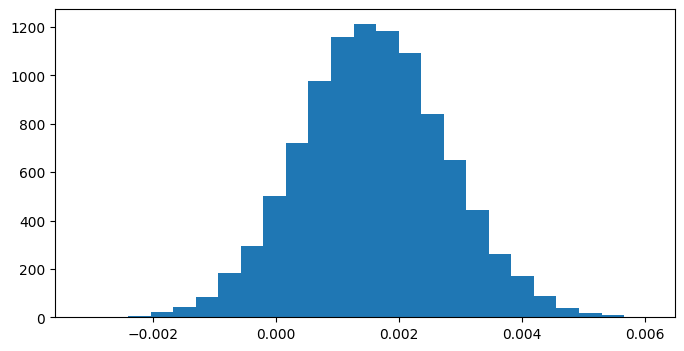

In [31]:
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [32]:
# simulate dist under null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)


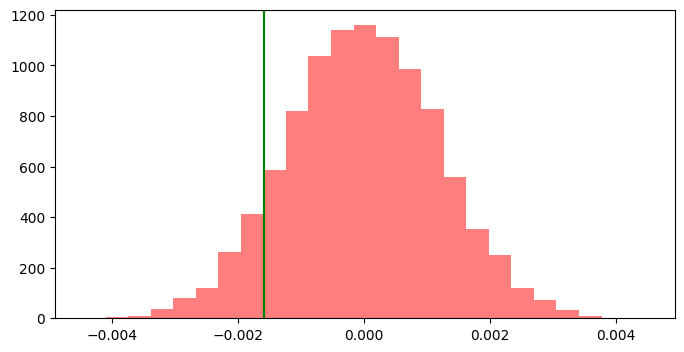

In [33]:
# plot null dist
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25, alpha = 0.5, color = 'red')

#plot observed statistic
control_mean = df2[df2['group'] == 'control']['converted'].mean()
treatment_mean = df2[df2['group'] == 'treatment']['converted'].mean()
obs_diff = treatment_mean - control_mean
plt.axvline(obs_diff, c='green')

plt.show()

In [34]:
# find p-value

(null_vals > obs_diff).mean()

0.9052

p value of 0.9 >= 0, therefore we fail to reject the null hypothesis.

There is no significant impact for the new page

In [35]:
import statsmodels.api as sm

convert_old = df2[(df2["converted"] == 1) & (df2["landing_page"] == "old_page")]['user_id'].nunique()
convert_new = df2[(df2["converted"] == 1) & (df2["landing_page"] == "new_page")]['user_id'].nunique()
n_old = df2[df["landing_page"] == "old_page"]['user_id'].nunique()
n_new = df2[df["landing_page"] == "new_page"]['user_id'].nunique()

In [36]:
#Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [37]:
# Print Z Score and P_Value
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [41]:
# linear regression

#create the intercept

df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,11:48.6,control,old_page,0,1
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,0,1
3,853541,28:03.1,treatment,new_page,0,1
4,864975,52:26.2,control,old_page,1,1


In [42]:
# Create ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2["ab_page"] = df2.group.apply(lambda x: 1 if (x == "treatment") else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,11:48.6,control,old_page,0,1,0
1,804228,01:45.2,control,old_page,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1
3,853541,28:03.1,treatment,new_page,0,1,1
4,864975,52:26.2,control,old_page,1,1,0


In [43]:
# fit the regression model

model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Oct 2024   Pseudo R-squ.:               8.085e-06
Time:                        12:11:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [44]:
np.exp(results.params)

,0
intercept,0.136863
ab_page,0.985115


When looking at:

1. Sampling Distribution
2. Z-tests
3. Logistic Regression

All point to rejecting the null hypothesis. The new webpage has little to no impact on conversion.